In [1]:
import pandas as pd
from bnpa.CausalNetwork import CausalNetwork

In [2]:
my_cbn = CausalNetwork.from_tsv("data/NPANetworks/Hs_CFA_Apoptosis_backbone.tsv",
                                "data/NPANetworks/Hs_CFA_Apoptosis_downstream.tsv")

In [3]:
datasets = dict()

datasets["CS (2m) + Sham (3m)"] = pd.read_table("./data/COPD1/CS (2m) + Sham (3m).tsv")
datasets["CS (2m) + Sham (5m)"] = pd.read_table("./data/COPD1/CS (2m) + Sham (5m).tsv")
datasets["CS (4m) + Sham (1m)"] = pd.read_table("./data/COPD1/CS (4m) + Sham (1m).tsv")
datasets["CS (4m) + Sham (3m)"] = pd.read_table("./data/COPD1/CS (4m) + Sham (3m).tsv")
datasets["CS (5m)"] = pd.read_table("./data/COPD1/CS (5m).tsv")
datasets["CS (7m)"] = pd.read_table("./data/COPD1/CS (7m).tsv")

for data_id, dataset in datasets.items():
    datasets[data_id] = dataset.rename(columns={"nodeLabel": "nodeID", "foldChange": "logFC"})

In [4]:
results = my_cbn.compute_npa(datasets)

In [5]:
display(results.global_info())

,NPA,var,ci_lower,ci_upper,o_value,k_value
CS (2m) + Sham (3m),0.007157,3.612355e-06,0.003432,0.010882,0.000,1.000
CS (2m) + Sham (5m),0.001191,2.181921e-07,0.000275,0.002107,0.074,1.000
CS (4m) + Sham (1m),0.076700,1.599542e-05,0.068861,0.084539,0.000,1.000
CS (4m) + Sham (3m),0.036512,9.365318e-06,0.030514,0.042510,0.000,1.000
CS (5m),0.102559,1.526669e-05,0.094901,0.110217,0.000,1.000
CS (7m),0.085898,1.909044e-05,0.077335,0.094462,0.000,1.000


In [7]:
display(results.node_info("CS (2m) + Sham (5m)"))

attr,contr,coeff,var,ci_lower,ci_upper,p_value
deg(p(MGI:Lmnb1)),0.00%,0.001512,0.000041,-0.011054,0.014077,0.406805
p(MGI:Bcl2a1b),0.01%,0.002494,0.00003,-0.008185,0.013173,0.323573
p(MGI:Nfkbie),0.06%,-0.006205,0.000334,-0.042034,0.029624,0.367141
act(p(MGI:Pmaip1)),1.30%,0.024373,0.000096,0.005162,0.043584,0.006448
act(p(MGI:Foxo1)),2.00%,-0.036496,0.000098,-0.055932,-0.017059,0.000117
...,...,...,...,...,...,...
p(MGI:Tnfrsf1b),0.09%,0.007979,0.000052,-0.006193,0.022152,0.134898
act(p(MGI:Dffa)),0.01%,0.002219,0.000017,-0.005888,0.010326,0.29583
p(MGI:Birc2),0.01%,-0.002091,0.000023,-0.011572,0.00739,0.332747
"p(SFAM:""MAPK JNK Family"")",0.06%,0.004436,0.000062,-0.010973,0.019845,0.286307


In [8]:
results.node_attributes()

['contr', 'coeff', 'var', 'ci_lower', 'ci_upper', 'p_value']

In [11]:
display(results.node_info("contr"))

data,CS (2m) + Sham (3m),CS (2m) + Sham (5m),CS (4m) + Sham (1m),CS (4m) + Sham (3m),CS (5m),CS (7m)
deg(p(MGI:Lmnb1)),0.37%,0.00%,0.44%,0.35%,0.43%,0.40%
p(MGI:Bcl2a1b),0.03%,0.01%,0.06%,0.05%,0.08%,0.10%
p(MGI:Nfkbie),0.74%,0.06%,0.40%,0.59%,0.17%,0.04%
act(p(MGI:Pmaip1)),2.07%,1.30%,1.87%,1.98%,1.82%,1.83%
act(p(MGI:Foxo1)),0.11%,2.00%,0.01%,0.00%,0.01%,0.00%
...,...,...,...,...,...,...
p(MGI:Tnfrsf1b),0.38%,0.09%,0.39%,0.39%,0.42%,0.39%
act(p(MGI:Dffa)),0.14%,0.01%,0.17%,0.11%,0.16%,0.13%
p(MGI:Birc2),0.12%,0.01%,0.20%,0.17%,0.23%,0.26%
"p(SFAM:""MAPK JNK Family"")",0.02%,0.06%,0.16%,0.13%,0.21%,0.21%


In [12]:
results.distributions()

['o_distribution', 'k_distribution']

<Figure size 640x480 with 0 Axes>

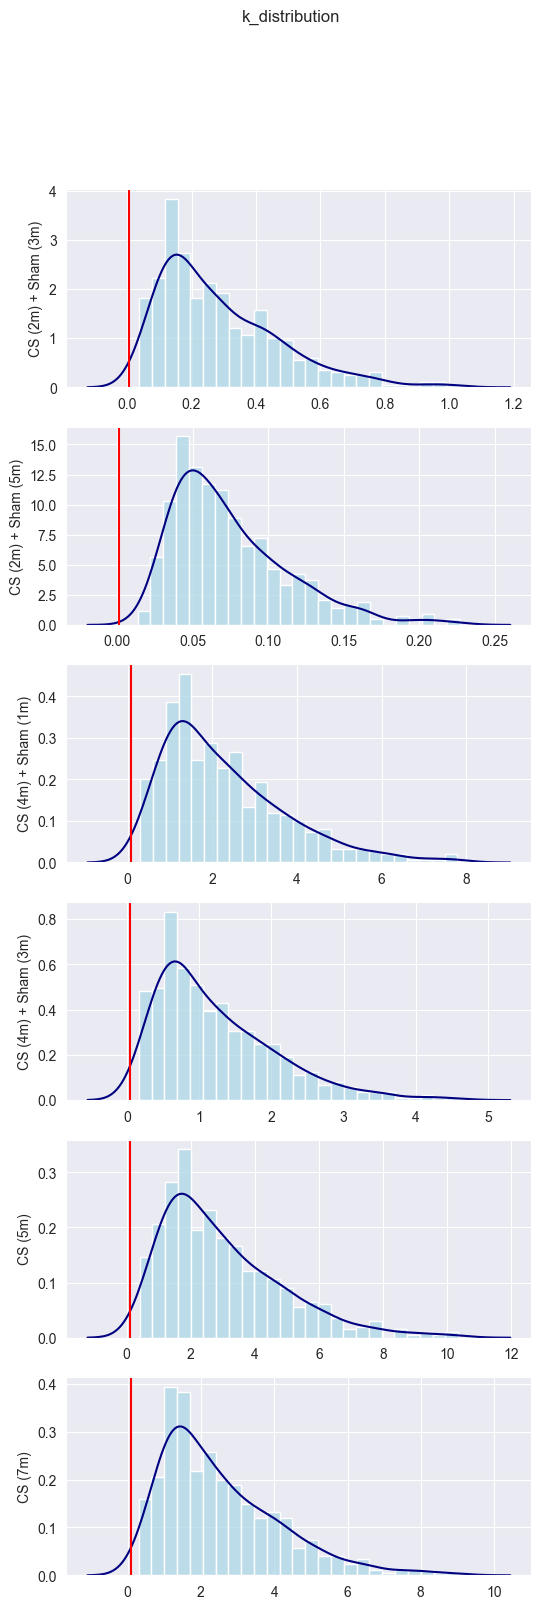

In [13]:
results.plot_distribution('k_distribution')

In [6]:
import py4cytoscape as p4c
p4c.cytoscape_version_info()

{'apiVersion': 'v1',
 'cytoscapeVersion': '3.9.1',
 'automationAPIVersion': '1.6.0',
 'py4cytoscapeVersion': '1.6.0'}

In [7]:
results.display()

Applying default style...
Applying preferred layout
